<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Modelo de lenguaje con tokenización por palabras

- Procesamiento del Lenguaje Natural - FIUBA
- Autor: Leandro Saraco
- CEIA
- Septiembre 2024


## Consigna
- 1. Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- 2. Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- 3. Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- 4. Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Embedding, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

## 1. Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

Como fuente de datos se utilizará el dataset de reviews de películas de IMDB.

El dataset se puede descargar fácilmente usando tensorflow_datasets:

In [2]:
# %pip install tensorflow_datasets

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Cargo el dataset de IMDB
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Inicializo listas
train_reviews = []
test_reviews = []

# El dataset original viene dividido en train y test para hacer aprendizaje supervisado de sentiment análisis.
# en este caso queremos sólo los textos, por lo cual se junta todo para formar el corpus.
for review, _ in tfds.as_numpy(dataset['train']):
    train_reviews.append(review.decode('utf-8'))

for review, _ in tfds.as_numpy(dataset['test']):
    test_reviews.append(review.decode('utf-8'))

corpus = train_reviews + test_reviews


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.QVMB8Y_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.QVMB8Y_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.QVMB8Y_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Vemos que hay 50000 reviews y cada una de ellas es un documento dentro de nuestro corpus

In [4]:
# Inspección rápida de qué tiene el corpus
print(f"El corpus tiene {len(corpus)} documentos.")
corpus[random.randint(0,len(corpus))]

El corpus tiene 50000 documentos.


'this particular title is very interesting. the whole movie was like watching a ninja RPG, which is really cool. three magical swords, three clans, a horrible demon, a political power, yotoden has it all. the animation is decent, but a little grainy, the story is top notch, and the fight scenes are real cool. one thing that really looks good in this movie are the monsters. they are pretty freaky. if you liked blood reign and ninja scroll, yotoden is the one to see.'

### Elección del tamaño del contexto

In [5]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# Segmentamos el texto con la utilidad de Keras
segmented_reviews = [text_to_word_sequence(sentence) for sentence in corpus]

In [6]:
# calculamos la longitud de cada secuencia
length_reviews = [len(sentence) for sentence in segmented_reviews]

(array([1.3249e+04, 2.1902e+04, 7.3840e+03, 3.4650e+03, 1.8140e+03,
        9.7600e+02, 5.7900e+02, 4.0900e+02, 1.9500e+02, 7.0000e+00,
        4.0000e+00, 4.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   6.  ,  130.35,  254.7 ,  379.05,  503.4 ,  627.75,  752.1 ,
         876.45, 1000.8 , 1125.15, 1249.5 , 1373.85, 1498.2 , 1622.55,
        1746.9 , 1871.25, 1995.6 , 2119.95, 2244.3 , 2368.65, 2493.  ]),
 <BarContainer object of 20 artists>)

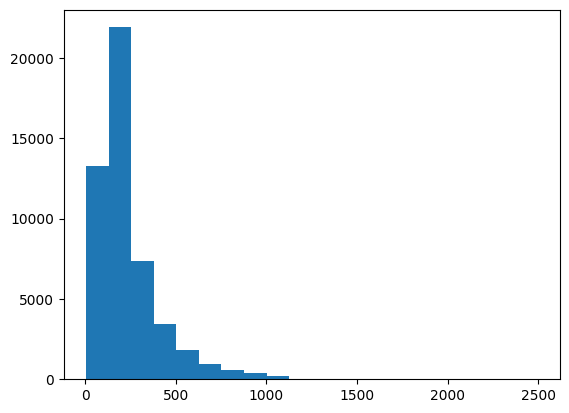

In [7]:
# podemos ver su distribución
plt.hist(length_reviews,bins=20)

In [8]:
# A partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. 
# Una opción es tomar un percentil. Por ejemplo, el percentil 90

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_reviews, 90)-1)
print(f"max_context_size si se eligiera por percentil (90%): {max_context_size}")

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana

max_context_size si se eligiera por percentil (90%): 458


- Como criterio se eligirá un tamaño de contexto que tenga sentido para generar una oración dentro de una reseña de una película.
- Además, se quiere un tamaño de contexto pequeño para poder generar más cantidad de secuencias desde un mismo review y así tener mayor cantidad de datos de entrenamiento y validación.

In [9]:
# Se separa cada reviews en oraciones y luego se segmenta el texto
import re 

def split_into_sentences(paragraph):
    sentences = re.split(r'(?<=[.!?]) +', paragraph)  # Criterio: un punto (.) seguido de un espacio
    return sentences


all_sentences = [split_into_sentences(review) for review in corpus]
segmented_sentences = [text_to_word_sequence(sentence) for sentences in all_sentences for sentence in sentences]


(0.0, 200.0)

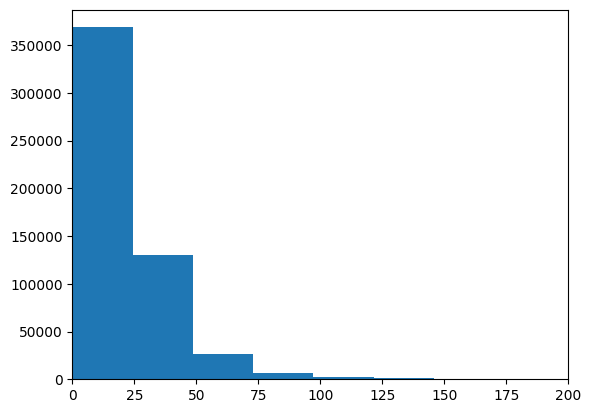

In [10]:
# Se plotea un histograma de tamaño en palabras de las oraciones
length_sentences = [len(sentence) for sentence in segmented_sentences]
plt.hist(length_sentences,bins=40)
plt.xlim(0, 200) 

Se elige entonces un tamaño de secuencia de 18 palabtas

In [11]:
max_context_size = 18

## 2. Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Se reduce el tamaño del vocabulario para poder manejar los modelos adecuadamente
# con los recursos que se tienen en Colab
max_vocab_size = 10000
tok = Tokenizer(num_words=max_vocab_size)

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [13]:
#tokenized_sentences[0]

In [14]:
#segmented_sentences[0]

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los reviews tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [15]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.4, random_state=42)

In [16]:
print(f"Longitud del set de train antes de hacer data augmentation: {len(tokenized_sentences_train)}")

Longitud del set de train antes de hacer data augmentation: 322099


Como ya se tiene bastante contenido, no se utilizará ninguna técnica de data augmentation.
Sin embargom una posibilidad sería generar secuencias del tamaño fijado a partir de secuencias de tamaño más grande

In [17]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
    if len(sent) > (max_context_size+1):
        extra = len(sent)-(max_context_size+1) + 1
        for i in range(extra):
          tok_sent.append(sent[i:i+max_context_size+1])
    else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
        tok_sent.append(sent)
        
print(f"Tamaño de datos luego de crear subsecuencias: {len(tok_sent)}")


Tamaño de datos luego de crear subsecuencias: 2413288


In [18]:
# Se generan las secuencias de entrenamiento forzando un tamaño fijo, ya sea cortando la oración o aplicando padding.
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seqs = pad_sequences(tokenized_sentences_train, maxlen=max_context_size+1, padding='pre')

In [19]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [20]:
y.shape

(322099, 18)

In [21]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size = max_vocab_size
vocab_size

10000

In [22]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'and': 2, 'a': 3, 'of': 4, 'to': 5, 'is': 6, 'br': 7, 'in': 8, 'it': 9, 'i': 10, 'this': 11, 'that': 12, 'was': 13, 'as': 14, 'for': 15, 'with': 16, 'movie': 17, 'but': 18, 'film': 19, 'on': 20, 'not': 21, 'you': 22, 'are': 23, 'his': 24, 'have': 25, 'be': 26, 'one': 27, 'he': 28, 'all': 29, 'at': 30, 'by': 31, 'an': 32, 'they': 33, 'so': 34, 'who': 35, 'from': 36, 'like': 37, 'or': 38, 'just': 39, 'her': 40, 'out': 41, 'about': 42, 'if': 43, "it's": 44, 'has': 45, 'there': 46, 'some': 47, 'what': 48, 'good': 49, 'when': 50, 'more': 51, 'very': 52, 'up': 53, 'no': 54, 'time': 55, 'my': 56, 'even': 57, 'would': 58, 'she': 59, 'which': 60, 'only': 61, 'really': 62, 'see': 63, 'story': 64, 'their': 65, 'had': 66, 'can': 67, 'me': 68, 'well': 69, 'were': 70, 'than': 71, 'much': 72, 'we': 73, 'bad': 74, 'been': 75, 'get': 76, 'do': 77, 'great': 78, 'other': 79, 'will': 80, 'also': 81, 'into': 82, 'people': 83, 'because': 84, 'how': 85, 'first': 86, 'him': 87, 'most': 88, "don't":

In [23]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'was': 78224, 'this': 133215, 'absolutely': 2972, 'movie': 76715, 'an': 39687, 'terrible': 3157, 'christopher': 734, 'by': 39865, 'in': 144942, 'michael': 2382, 'be': 48980, 'ironside': 57, "don't": 16110, 'lured': 49, 'or': 32139, 'walken': 201, 'are': 51114, 'must': 6323, 'history': 2490, 'role': 6008, 'their': 20129, 'simply': 3814, 'worst': 5136, 'both': 6503, 'great': 16911, 'actors': 8510, 'but': 78425, "movie's": 799, 'not': 55394, 'acting': 12472, 'redeem': 130, 'storyline': 1532, 'ridiculous': 1862, 'could': 14679, 'even': 23805, 'is': 165285, 'piece': 3000, 'propaganda': 412, 'early': 3055, 'nineties': 69, 'us': 6875, 'most': 16715, 'cases': 292, 'the': 321966, 'pathetic': 972, 'scenes': 9954, 'rebels': 106, 'making': 5625, 'revolutions': 17, 'columbian': 6, 'were': 19240, 'when': 26537, 'those': 9041, 'for': 76596, 'her': 25496, 'devoid': 224, 'pseudo': 228, 'meaning': 964, 'affair': 705, 'alonso': 14, 'nothing': 8067, 'emotional': 1326, 'of': 198

## 3. Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.


Callback para calcular la perplejidad al finalizar el train de un epoch

In [24]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### Funciones para evaluar la performance del modelo

Función para predecir próxima palabra

In [25]:
def next_word(text,model):
    """Función para predecir cuál será la próxima palabra."""

    # Encodeamos
    encoded = tok.texts_to_sequences([text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return text + ' ' + out_word

Función para generar una secuencia

In [26]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
      # generate a fixed number of words
    for _ in range(n_words):
          # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

          # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

          # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

          # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

### 3.a. Usando Simple RNN

In [27]:
model_rnn = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model_rnn.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model_rnn.add(SimpleRNN(300, return_sequences=True))
# model.add(Dropout(0.2))

model_rnn.add(SimpleRNN(300, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model_rnn.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model_rnn.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_rnn.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 50)       │       500,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 300)      │       105,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 300)      │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 10001)    │     3,010,301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,795,951 (14.48 MB)

 Trainable params: 3,795,951 (14.48 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

#### Entrenamiento

- No se usa el callback de perplejidad ya que causa un problema de overflow de RAM que genera que se resetee el runtime de python
- Indirectmente se evalua la performance del modelo mediante la función de pérdida y la generación de secuencias en las etapas subsiguientes

In [28]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model_rnn.fit(X, y, epochs=20, batch_size=256)

Epoch 1/20


I0000 00:00:1727057366.790450     115 service.cc:145] XLA service 0x557a4d8153d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727057366.790514     115 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727057366.790519     115 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1727057366.969286     115 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


   3/1259 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - loss: 9.1480  

I0000 00:00:1727057370.027746     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1258/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.2719

W0000 00:00:1727057424.653025     118 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 62s 45ms/step - loss: 5.2714
Epoch 2/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 4.4946
Epoch 3/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 4.2824
Epoch 4/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 4.1711
Epoch 5/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 4.0885
Epoch 6/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 4.0398
Epoch 7/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.9891
Epoch 8/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.9530
Epoch 9/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.9226
Epoch 10/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.8874
Epoch 11/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.8673
Epoch 12/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.8425
Epoch 13/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.8261
Epoch 14/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.8029
Epoch 15/20


#### Predicción de próxima palabra

In [30]:
next_word("The movie was",model_rnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


'The movie was bad'

In [31]:
next_word("The actor is",model_rnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'The actor is great'

#### Guardado del modelo

In [36]:
model_rnn.save("model_simpleRNN.keras")

### 3.b. Utilizando LSTM

In [33]:
model_lstm = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model_lstm.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model_lstm.add(SimpleRNN(300, return_sequences=True))
# model.add(Dropout(0.2))

model_lstm.add(SimpleRNN(300, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model_lstm.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model_lstm.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 50)       │       500,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 300)      │       105,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 300)      │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 10001)    │     3,010,301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,795,951 (14.48 MB)

 Trainable params: 3,795,951 (14.48 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
hist = model_lstm.fit(X, y, epochs=20, batch_size=256)

Epoch 1/20


W0000 00:00:1727058785.558504     117 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1258/1259 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.1628

W0000 00:00:1727058845.854026     115 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 64s 48ms/step - loss: 5.1622
Epoch 2/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 4.4073
Epoch 3/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 4.2393
Epoch 4/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 4.1390
Epoch 5/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.9418
Epoch 9/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.9069
Epoch 10/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.8810
Epoch 11/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.8533
Epoch 12/20
 841/1259 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 3.8292

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1259/1259 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 3.7204


#### Predicción de próxima palabra

In [38]:
next_word("The movie was",model_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


'The movie was awful'

In [39]:
next_word("The actor is",model_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'The actor is excellent'

#### Guardado del modelo

In [41]:
model_lstm.save("model_lstm.keras")

### 3.c Utilizando GRU

In [42]:
model_gru = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model_gru.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model_gru.add(GRU(300, return_sequences=True))
# model.add(Dropout(0.2))

model_gru.add(GRU(300, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model_gru.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model_gru.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 50)       │       500,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 300)      │       316,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 300)      │       541,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 10001)    │     3,010,301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,368,951 (16.67 MB)

 Trainable params: 4,368,951 (16.67 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
hist = model_gru.fit(X, y, epochs=20, batch_size=256)

Epoch 1/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 150s 117ms/step - loss: 5.2335
Epoch 2/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.5751
Epoch 3/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 116ms/step - loss: 4.4155
Epoch 4/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.3352
Epoch 5/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.2785
Epoch 6/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 116ms/step - loss: 4.2336
Epoch 7/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.1969
Epoch 8/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.1604
Epoch 9/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.1296
Epoch 10/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.0992
Epoch 11/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.0799
Epoch 12/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.0525
Epoch 13/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s 117ms/step - loss: 4.0258
Epoch 14/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 147s

#### Predicción de próxima palabra

In [46]:
next_word("The movie was",model_gru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


'The movie was terrible'

In [47]:
next_word("The actor is",model_gru)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


'The actor is excellent'

#### Guardado del modelo

In [49]:
model_gru.save("model_gru.keras")

## 4. Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


Se generarán secuencias de 15 palabras por cada modelo, tomando el mismo input de entrada

In [51]:
input_text='A movie'


print("Modelo con simple RNN:",generate_seq(model_rnn, tok, input_text, max_length=max_context_size, n_words=15))
print("Modelo con LSTM:",generate_seq(model_lstm, tok, input_text, max_length=max_context_size, n_words=15))
print("Modelo con GRU:",generate_seq(model_gru, tok, input_text, max_length=max_context_size, n_words=15))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Modelo con simple RNN: A movie is not funny either funny either funny or funny either funny or bad movies anymore
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

Vemos que el modelo que mejor performance tiene pareciera ser el que utiliza LSTM. Veamos con beam search:

###  Beam search y muestreo aleatorio

In [52]:
# Funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [57]:
from scipy.special import softmax

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):
  """Función que selecciona candidatos para el beam search."""

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [60]:
# Predicción con beam search, se utiliza el modelo estocástico para evaluar el efecto de la temperatura
# Se utiliza el modelo con LSTM ya que parece ser el que dio mejores resultados
temp_ranges = [0.01,1,100]
for temp in temp_ranges:
    salidas = beam_search(model_rnn,num_beams=10,num_words=15,input="The movie was",temp=temp,mode='sto')
    print(f"Secuencia con temperatura {temp}",decode(salidas[0]))

Secuencia con temperatura 0.01 ['the movie was bad too bad too bad either funny or bad movie either bad or bad movies']
Secuencia con temperatura 1 ['the movie was good too bad it was ridiculous enough to do it again again again it seemed']
Secuencia con temperatura 100 ['the movie was puzzling accessible cries negative bela appropriate mistress for francis concrete sophie clooney lengths beers edith']


- Puede verse que con temperatura 0.01 hay mucha repetición de palabra (el modelo elige por probabilidades y seguramente esté obteniendo una palabra que aparece con mucha frecuencia en el vocabulario).
- Con temperatura 100 se ve que hay mucha variedad de palabras pero el texto no tiene coherencia.

Se repite el proceso con el modelo con GRU que tenía mucha repetición de palabras, para ver qué cambia:

In [61]:
# Predicción con beam search, se utiliza el modelo estocástico para evaluar el efecto de la temperatura
# Se utiliza el modelo con LSTM ya que parece ser el que dio mejores resultados
temp_ranges = [0.01,1,100]
for temp in temp_ranges:
    salidas = beam_search(model_gru,num_beams=10,num_words=15,input="The movie was",temp=temp,mode='sto')
    print(f"Secuencia con temperatura {temp}",decode(salidas[0]))

Secuencia con temperatura 0.01 ['the movie was terrible and predictable and funny too long too long too long too long too long']
Secuencia con temperatura 1 ["the movie was horrible too unbelievable and too predictable too bad it didn't work on it too instead"]
Secuencia con temperatura 100 ["the movie was alleged makeup man's meek nigel angela foxx abruptly 60 targets suggested full various decay concorde"]


- Se observa que en este caso, el modelo con temperatura=1 mejora muchos los resultados comparado con el uso de un generador de secuencias determinístico que se basa solo en la máxima probabilidad.